In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV4'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
TRAINING_SET_DIMENSION = 0.85
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_flip_add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train, theta=math.pi/2, standard_deviation=0.0005, increment_percentage=3)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(748000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v4(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64, 16)         64        
_________________________________________________________________
dense (Dense)                (None, 1, 64, 256)        4352  

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
731/731 [==============================] - 34s 27ms/step - loss: 1.5770 - val_loss: 2.3835
Epoch 2/100
731/731 [==============================] - 19s 25ms/step - loss: 1.2350 - val_loss: 1.1839
Epoch 3/100
731/731 [==============================] - 18s 25ms/step - loss: 1.1903 - val_loss: 1.1533
Epoch 4/100
731/731 [==============================] - 18s 25ms/step - loss: 1.1711 - val_loss: 1.1330
Epoch 5/100
731/731 [==============================] - 19s 25ms/step - loss: 1.1542 - val_loss: 1.1354
Epoch 6/100
731/731 [==============================] - 19s 26ms/step - loss: 1.1398 - val_loss: 1.1243
Epoch 7/100
731/731 [==============================] - 19s 26ms/step - loss: 1.1337 - val_loss: 1.1128
Epoch 8/100
731/731 [==============================] - 19s 26ms/step - loss: 1.1223 - val_loss: 1.1141
Epoch 9/100
731/731 [==============================] - 19s 26ms/step - loss: 1.1159 - val_loss: 1.1098
Epoch 10/100
731/731 [==============================] - 19s 25ms/step - l

# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

33/33 [==============================] - 0s 9ms/step - loss: 1.1066
1.106576919555664


## Loss

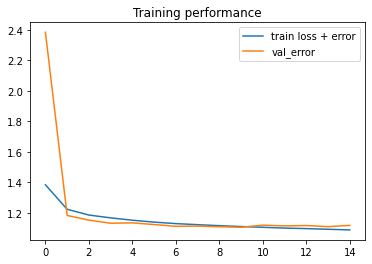

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

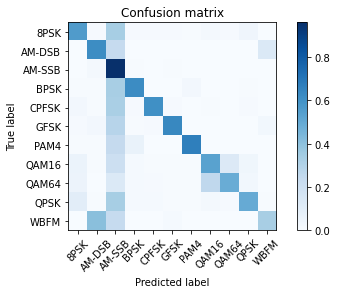

In [15]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

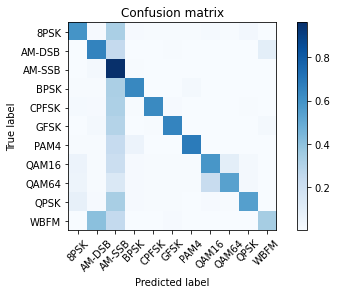

In [16]:
evaluationlib.plot_confusion_matrix(model, X_train, Y_train, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09361163820366857
Overall Accuracy:  0.09369144284821987
Overall Accuracy:  0.09254807692307693
Overall Accuracy:  0.11413673232908458
Overall Accuracy:  0.14114114114114115
Overall Accuracy:  0.21363910681955342
Overall Accuracy:  0.33293838862559244
Overall Accuracy:  0.5214761040532365
Overall Accuracy:  0.6593471810089021
Overall Accuracy:  0.7571090047393365
Overall Accuracy:  0.838371375694016
Overall Accuracy:  0.8557634278817139
Overall Accuracy:  0.8825781748564135
Overall Accuracy:  0.8894993894993894
Overall Accuracy:  0.8933889219773675
Overall Accuracy:  0.9045257284562926
Overall Accuracy:  0.8850502512562815
Overall Accuracy:  0.8920731707317073
Overall Accuracy:  0.8908872901678657
Overall Accuracy:  0.8864298194525335


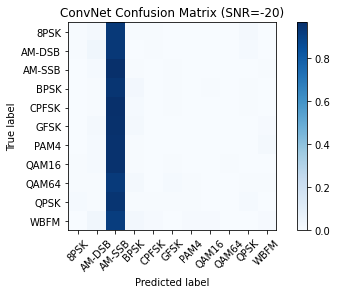

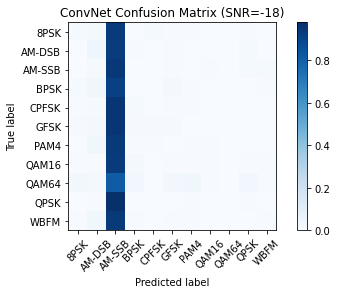

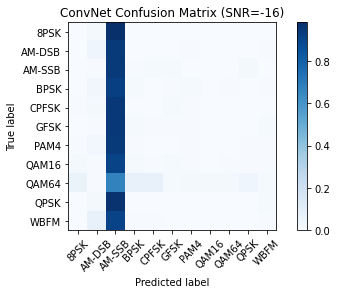

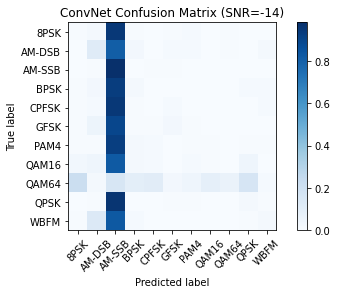

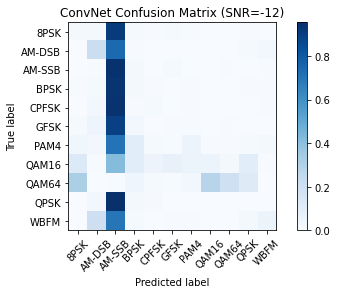

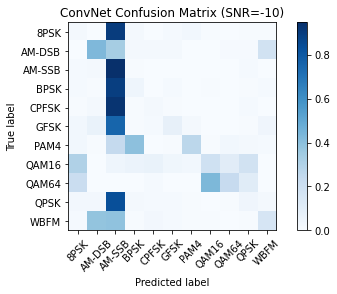

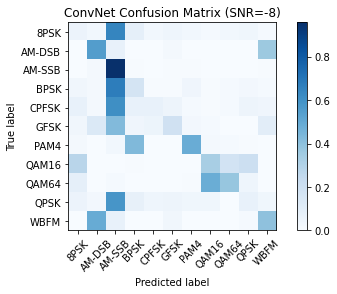

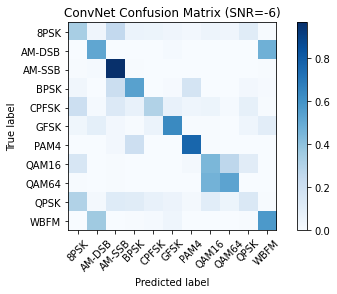

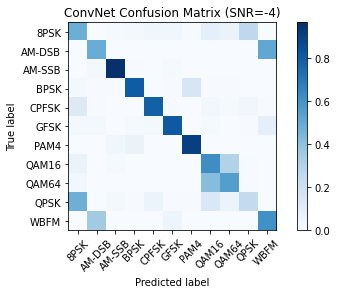

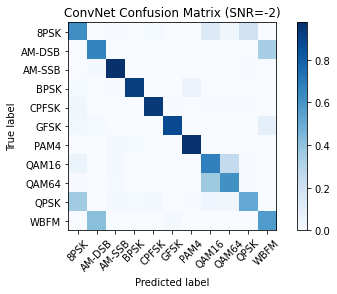

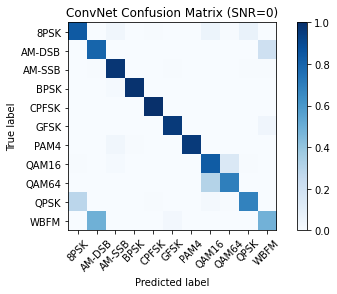

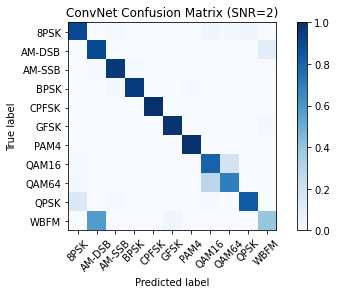

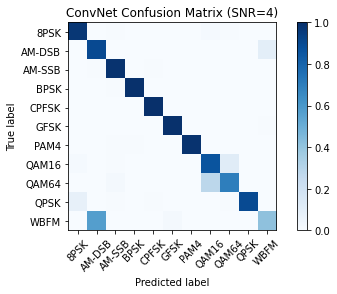

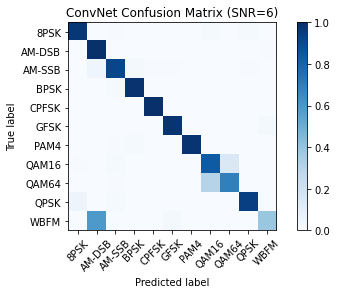

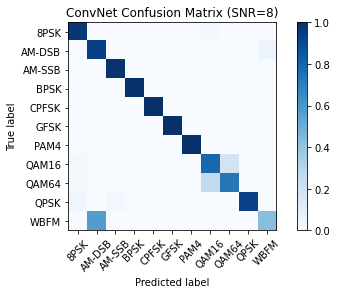

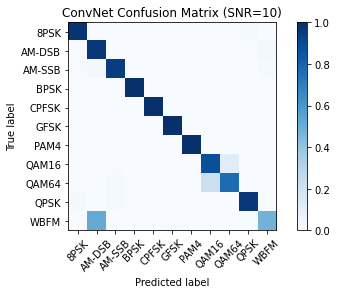

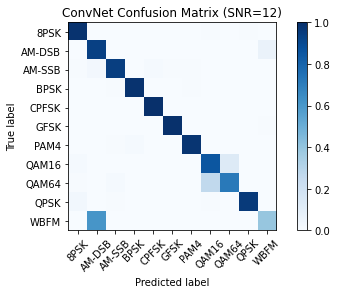

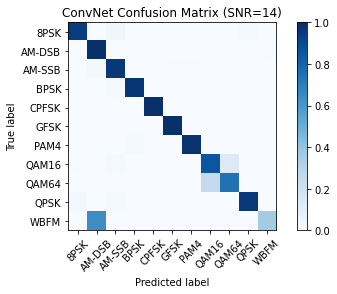

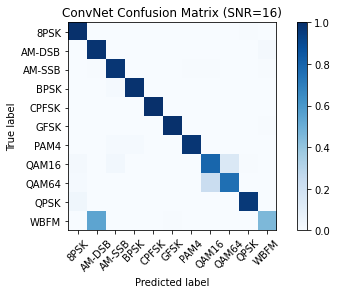

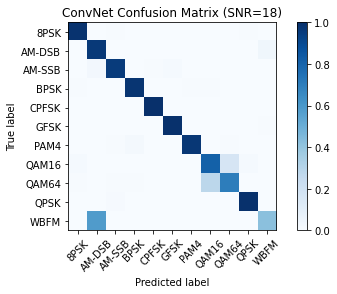

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

Overall Accuracy:  0.09671939696358424
Overall Accuracy:  0.09788275348441323
Overall Accuracy:  0.10068551842330763
Overall Accuracy:  0.12346344619365969
Overall Accuracy:  0.15897161221210498
Overall Accuracy:  0.2589104142138499
Overall Accuracy:  0.4023840206185567
Overall Accuracy:  0.6119610570236439
Overall Accuracy:  0.7610305958132045
Overall Accuracy:  0.823668384879725
Overall Accuracy:  0.8589401855208444
Overall Accuracy:  0.8819437011666488
Overall Accuracy:  0.8916569490087989
Overall Accuracy:  0.8889126255073703
Overall Accuracy:  0.8961484819225405
Overall Accuracy:  0.8991157984446575
Overall Accuracy:  0.8971088435374149
Overall Accuracy:  0.8990384615384616
Overall Accuracy:  0.8970210030004286
Overall Accuracy:  0.8988473553808036


{-20: 0.09671939696358424,
 -18: 0.09788275348441323,
 -16: 0.10068551842330763,
 -14: 0.12346344619365969,
 -12: 0.15897161221210498,
 -10: 0.2589104142138499,
 -8: 0.4023840206185567,
 -6: 0.6119610570236439,
 -4: 0.7610305958132045,
 -2: 0.823668384879725,
 0: 0.8589401855208444,
 2: 0.8819437011666488,
 4: 0.8916569490087989,
 6: 0.8889126255073703,
 8: 0.8961484819225405,
 10: 0.8991157984446575,
 12: 0.8971088435374149,
 14: 0.8990384615384616,
 16: 0.8970210030004286,
 18: 0.8988473553808036}

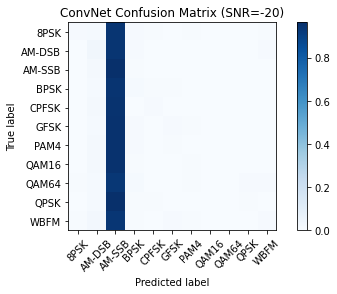

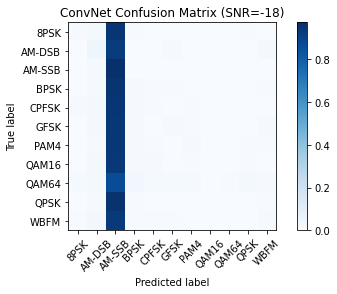

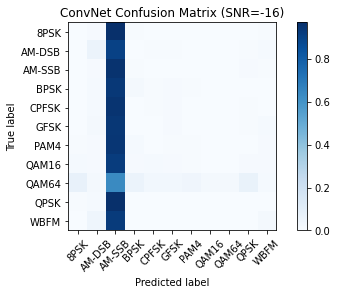

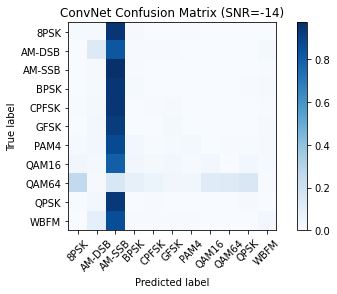

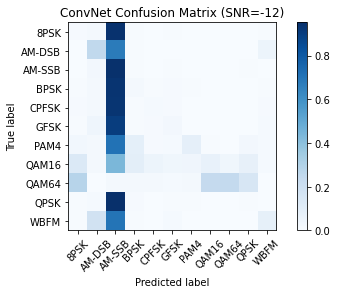

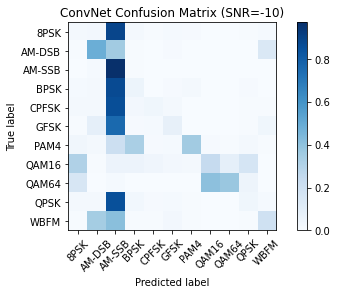

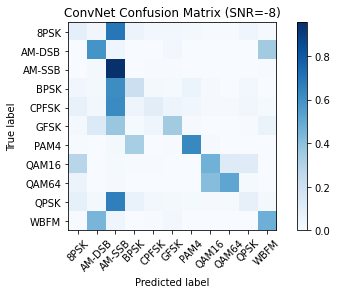

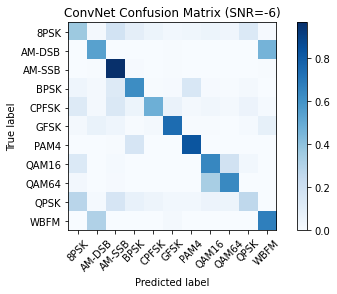

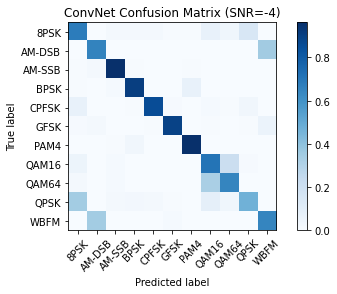

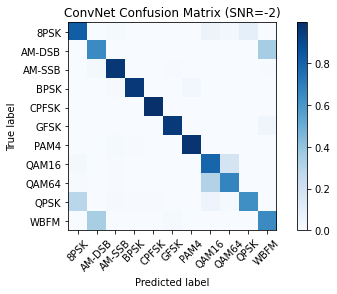

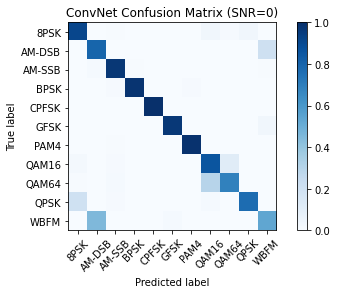

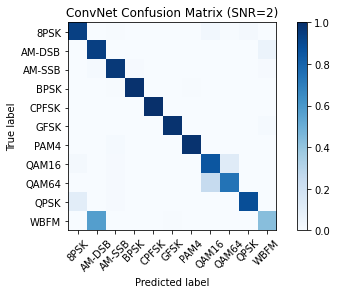

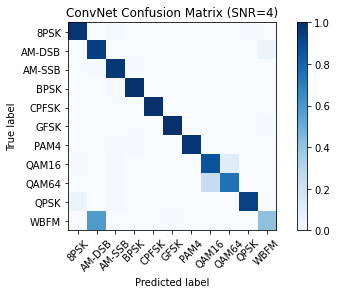

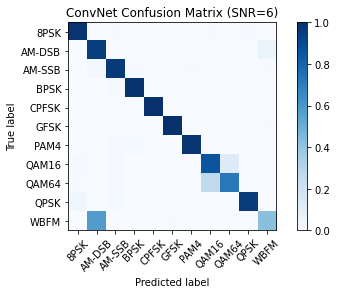

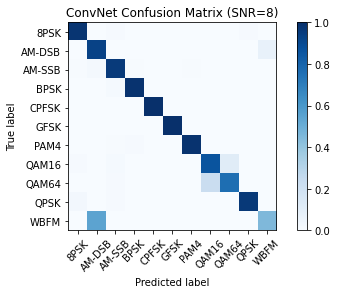

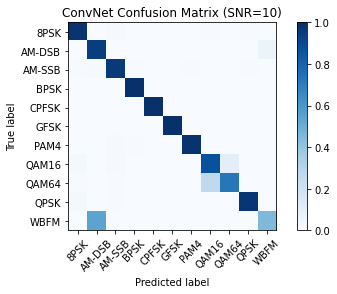

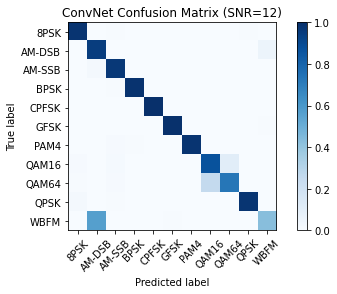

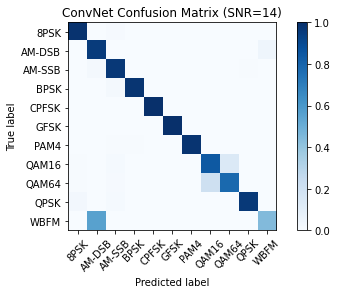

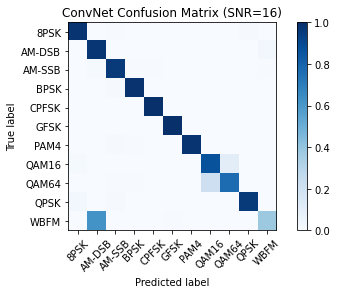

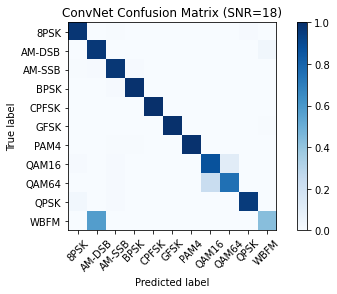

In [18]:
evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_train, Y_train, train_index, classes)

## Accuracy performance

In [19]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,11,14,21,33,52,65,75,83,85,88,88,89,90,88,89,89,88


In [20]:
import statistics

statistics.mean(acc.values())

0.5919103183332697

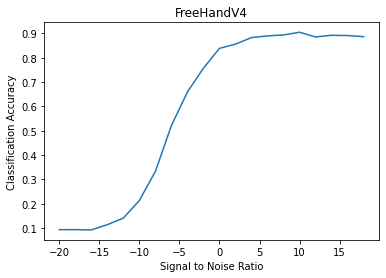

In [21]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)